<a href="https://colab.research.google.com/github/alaahaise/Model-IA-Unet-avec-PH2/blob/main/Model_IA_Unet_avec_PH2_boumed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless h5py
!pip install --upgrade tensorflow jax jaxlib
!pip install tensorflow==2.9.0
!pip uninstall tensorflow jax jaxlib -y
!pip install tensorflow jax jaxlib


  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
  Using cached jaxlib-0.4.28-cp310-cp310-manylinux2014_x86_64.whl (77.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.
  Using cached tensorflow-2.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.8 MB/s 

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Successfully uninstalled tensorflow-2.9.0
Found existing installation: jax 0.4.28
Uninstalling jax-0.4.28:
  Successfully uninstalled jax-0.4.28
Found existing installation: jaxlib 0.4.28
Uninstalling jaxlib-0.4.28:
  Successfully uninstalled jaxlib-0.4.28
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
  Using cached jaxlib-0.4.28-cp310-cp310-manylinux2014_x86_64.whl (77.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.5 MB/s eta 0:00:00
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuf

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
!pip install kaggle
!kaggle datasets download -d athina123/ph2dataset

Dataset URL: https://www.kaggle.com/datasets/athina123/ph2dataset
License(s): unknown
 97% 393M/405M [00:04<00:00, 117MB/s]
100% 405M/405M [00:04<00:00, 104MB/s]


In [ ]:
import zipfile
# Specify the path to the zip file
zip_file_path = '/content/ph2dataset.zip'

# Specify the directory where you want to extract the contents
extracted_dir_path = '/content/PH2'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)


In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define paths (adjust according to your dataset location)
image_path = '/content/PH2/trainx/'
mask_path = '/content/PH2/trainy/'

# Load and preprocess images and masks
def load_images_with_filenames(folder):
    images = []
    filenames = []
    for filename in glob.glob(os.path.join(folder, '*.bmp')):
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
            filenames.append(os.path.basename(filename))
    return images, filenames

images, image_files = load_images_with_filenames(image_path)
masks, mask_files = load_images_with_filenames(mask_path)

# Remove '_lesion' suffix from mask filenames
mask_files_stripped = [filename.replace('_lesion', '') for filename in mask_files]

# Find common filenames between image and mask files
common_files = set(image_files).intersection(mask_files_stripped)

# Filter images and masks based on common filenames
images_filtered = [img for img, fname in zip(images, image_files) if fname in common_files]
masks_filtered = [mask for mask, fname in zip(masks, mask_files) if fname.replace('_lesion', '') in common_files]

# Verify if images and masks are loaded properly and have the same size
print("Number of images loaded:", len(images_filtered))
print("Number of masks loaded:", len(masks_filtered))
print("Image shape:", images_filtered[0].shape)
print("Mask shape:", masks_filtered[0].shape)

# Resize images and masks to a common size, e.g., 256x256
IMG_HEIGHT, IMG_WIDTH = 256, 256

def resize_images(images, height, width):
    resized_images = [cv2.resize(image, (width, height)) for image in images]
    return np.array(resized_images)

images_resized = resize_images(images_filtered, IMG_HEIGHT, IMG_WIDTH)
masks_resized = resize_images(masks_filtered, IMG_HEIGHT, IMG_WIDTH)

# Convert masks to single channel
masks_resized_single_channel = [cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) for mask in masks_resized]

# Normalize images and masks
images_normalized = images_resized / 255.0
masks_normalized = np.expand_dims(np.array(masks_resized_single_channel) / 255.0, axis=-1)

# Ensure masks are binary (0 or 1)
masks_binary = np.where(masks_normalized > 0.5, 1, 0)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images_normalized, masks_binary, test_size=0.2, random_state=42)

# Check shapes to ensure they are as expected
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


Number of images loaded: 200
Number of masks loaded: 200
Image shape: (575, 764, 3)
Mask shape: (576, 767, 3)
X_train shape: (160, 256, 256, 3)
X_val shape: (40, 256, 256, 3)
y_train shape: (160, 256, 256, 1)
y_val shape: (40, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define the UNet model
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Downsampling
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Upsampling
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("best_unet_model.keras", save_best_only=True, monitor="val_loss", mode="min"),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
    ]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.6918 - loss: 0.6753 - val_accuracy: 0.6759 - val_loss: 0.6425
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 916ms/step - accuracy: 0.6807 - loss: 0.6307 - val_accuracy: 0.6759 - val_loss: 0.6246
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 895ms/step - accuracy: 0.6750 - loss: 0.6234 - val_accuracy: 0.6759 - val_loss: 0.6199
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 901ms/step - accuracy: 0.6833 - loss: 0.6051 - val_accuracy: 0.6759 - val_loss: 0.5980
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 709ms/step - accuracy: 0.6825 - loss: 0.7884 - val_accuracy: 0.6759 - val_loss: 0.6595
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 712ms/step - accuracy: 0.6608 - loss: 0.6608 - val_accuracy: 0.6759 - val_loss: 0.6238
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - accuracy: 0.6575 - loss: 0.6349 - val_accuracy: 0.6759 - val_loss: 0.6375
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - accuracy: 0.6816 - loss: 0.6116 - val_accuracy

2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 147ms/step - accuracy: 0.7785 - loss: 0.4808
Validation Loss: 0.48031049966812134
Validation Accuracy: 77.88%


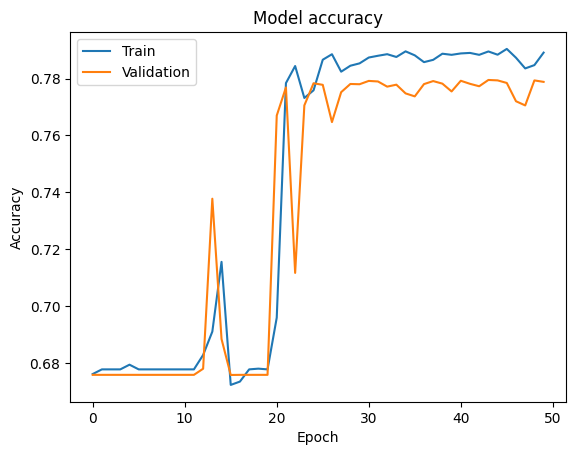

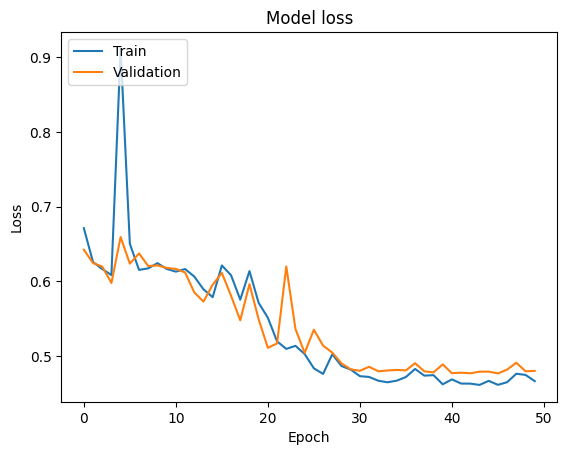

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


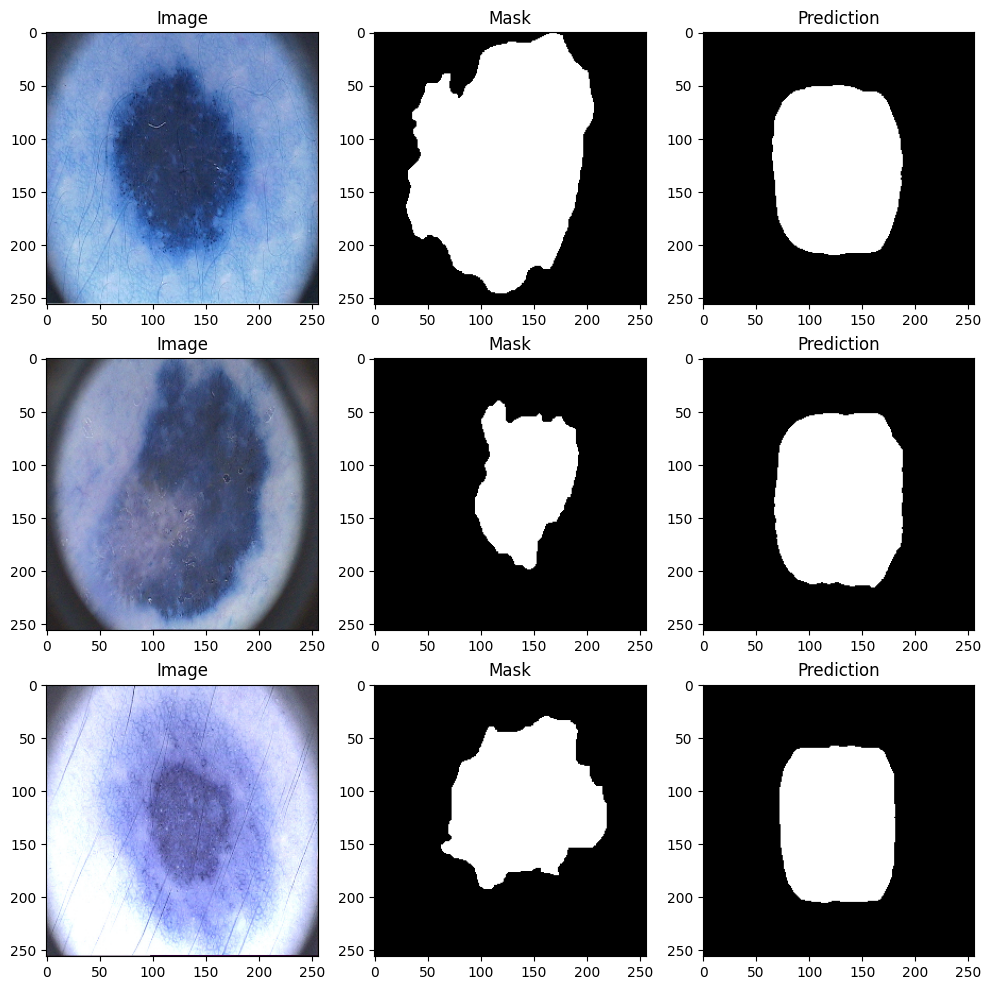

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualize predictions
def plot_sample(X, y, preds, binary=True):
    if binary:
        preds = np.where(preds > 0.5, 1, 0)

    plt.figure(figsize=(12, 12))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(X[i])
        plt.title("Image")

        plt.subplot(3, 3, i*3+2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title("Mask")

        plt.subplot(3, 3, i*3+3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Prediction")
    plt.show()

# Predict on validation set
preds_val = model.predict(X_val, verbose=1)

# Plot some samples
plot_sample(X_val, y_val, preds_val)

In [ ]:
# Extract the validation accuracy from the history object
val_accuracy = history.history['val_accuracy']

# Find the highest validation accuracy
best_val_accuracy = max(val_accuracy)

# Print the highest validation accuracy
print(f"Highest validation accuracy achieved: {best_val_accuracy * 100:.2f}%")


Highest validation accuracy achieved: 77.95%
